In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

from openpathsampling.analysis.tis_analysis import TISTransition

storage = paths.storage.Storage("toy_tis.nc")
print len(storage.sample)

12482


In [2]:
print len(storage.sampleset)

10001


In [3]:
print storage.sampleset[0].samples

[<Sample @ 0x118bdb1d0>, <Sample @ 0x118be2ad0>, <Sample @ 0x118bdd9d0>, <Sample @ 0x118d2ad90>, <Sample @ 0x118d1ab90>, <Sample @ 0x118d06810>, <Sample @ 0x11929dfd0>]


In [4]:
ensembles = [[s.ensemble for s in storage.sampleset[0] if s.replica==r][0] for r in range(-1, len(storage.ensemble)-2)]

In [5]:
ensembles

In [6]:
stateA = ensembles[1].ensembles[2].ensemble.volume.volume1
stateB = ensembles[1].ensembles[2].ensemble.volume.volume2
interfaces = [e.ensembles[1].ensemble2.volume for e in ensembles[1:]]
op = ensembles[1].ensembles[0].ensemble.volume.orderparameter

In [7]:
lmax = [e.ensembles[1].ensemble2.volume.lambda_max for e in ensembles[1:]]
print lmax

[-0.3, -0.25, -0.2, -0.13, -0.05, 0.0]


In [8]:
storage.variables['sample_ensemble_idx'][:]
tt = storage.variables['trajectory_snapshot_idx']
all_lengths =  [len(storage.variables['trajectory_snapshot_idx'][nn]) for nn in range(len(storage.trajectory))]

In [9]:
%%time
tis = TISTransition(stateA=stateA, stateB=stateB, orderparameter=op, interfaces=interfaces, storage=storage)

CPU times: user 700 µs, sys: 173 µs, total: 873 µs
Wall time: 771 µs


In [10]:
tis.ensembles = ensembles[1:]

In [11]:
%%time
tis.all_statistics(samples=storage.sample, weights=None, force=True)

CPU times: user 4min 20s, sys: 10.8 s, total: 4min 31s
Wall time: 12min 45s


In [12]:
print tis.histograms

{'pathlength': {<openpathsampling.ensemble.SequentialEnsemble object at 0x118bdb210>: <openpathsampling.analysis.histogram.Histogram object at 0x13a553e50>, <openpathsampling.ensemble.SequentialEnsemble object at 0x118bdd110>: <openpathsampling.analysis.histogram.Histogram object at 0x13a553e90>, <openpathsampling.ensemble.SequentialEnsemble object at 0x118d1a8d0>: <openpathsampling.analysis.histogram.Histogram object at 0x13a553ed0>, <openpathsampling.ensemble.SequentialEnsemble object at 0x118be2cd0>: <openpathsampling.analysis.histogram.Histogram object at 0x13a553f10>, <openpathsampling.ensemble.SequentialEnsemble object at 0x1100f0f10>: <openpathsampling.analysis.histogram.Histogram object at 0x13a553b50>, <openpathsampling.ensemble.SequentialEnsemble object at 0x118d2af50>: <openpathsampling.analysis.histogram.Histogram object at 0x11929d590>}}


In [13]:
# for sample_set[ssetid], if exists sample in `ensemble`, return list of op(sample.trajectory)
#storage.query_orderparameter_trajectory(orderparameter, ensemble=None, replica=None, step=None, trial=False) #

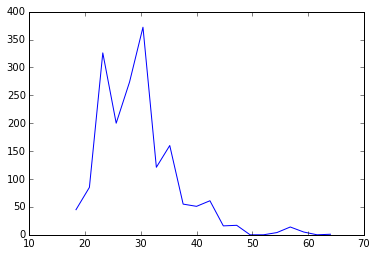

In [14]:
tis.histograms['pathlength'][ensembles[2]].plt_plot()

In [15]:
%%time
tis.ensemble_statistics(ensemble=ensembles[1], samples=storage.sample, weights=None, force=True)

CPU times: user 1.43 s, sys: 38.2 ms, total: 1.47 s
Wall time: 1.46 s


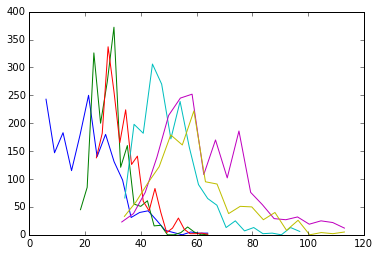

In [18]:
for ens in ensembles[1:]:
    tis.histograms['pathlength'][ens].plt_plot()